In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from tqdm.notebook import tqdm
import numpy as np
import random

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, RocCurveDisplay, auc
from matplotlib import pyplot as plt

tqdm.pandas()


SEED = 254290

np.random.seed(SEED)
random.seed(SEED)

narysuj krzywe FAR,
FRR,
wyznacz EER
narysuj ROC


zmierz PSNR,
SSIM oraz BRISQUE.

In [2]:
registration_df = pd.read_csv("./data/registration.csv")
registration_df

,image,identity
0,050987.png,15
1,180629.png,97
2,108845.png,172
3,163175.png,229
4,165766.png,298
...,...,...
75,022376.png,9535
76,061873.png,9625
77,053384.png,9886
78,129996.png,10038


In [3]:
IMAGES_DIR = Path("./data/img_align_celeba_png.7z")
MODEL = "VGG-Face"

In [4]:
from users_db import UsersDB

db = UsersDB(model=MODEL)

for _, row in tqdm(registration_df.iterrows(), total=len(registration_df)):
    img_fpath = IMAGES_DIR / row["image"]
    db.add_record(row["identity"], img_fpath)

2024-04-07 00:59:37.582512: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-07 00:59:37.642153: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 00:59:38.311438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


  0%|          | 0/80 [00:00<?, ?it/s]

2024-04-07 00:59:39.755641: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-07 00:59:39.809154: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
df1 = pd.read_csv("./data/df1.csv")
df1

,image,truth,identity
0,000010.png,False,6258
1,000028.png,False,4638
2,000143.png,False,1308
3,000216.png,False,1308
4,000361.png,False,1308
...,...,...,...
1335,201335.png,True,6258
1336,201507.png,True,6074
1337,202086.png,True,5013
1338,202142.png,True,5013


In [6]:
df2 = pd.read_csv("./data/df2.csv")
df2

,image,truth,identity
0,000010.png,False,6258
1,000028.png,False,4638
2,000143.png,False,1308
3,000216.png,False,1308
4,000361.png,False,1308
...,...,...,...
1435,000251.png,False,2339
1436,199773.png,False,910
1437,176142.png,False,97
1438,196518.png,False,8455


In [7]:
df3 = pd.read_csv("./data/df3.csv")
df3

,image,truth,identity
0,000010.png,False,6258
1,000028.png,False,4638
2,000143.png,False,1308
3,000216.png,False,1308
4,000361.png,False,1308
...,...,...,...
295,201335.png,True,6258
296,201507.png,True,6074
297,202086.png,True,5013
298,202142.png,True,5013


In [8]:
df4 = pd.read_csv("./data/df4.csv")
df4

,image,truth,identity
0,000010.png,False,6258
1,000028.png,False,4638
2,000143.png,False,1308
3,000216.png,False,1308
4,000361.png,False,1308
...,...,...,...
295,201335.png,True,6258
296,201507.png,True,6074
297,202086.png,True,5013
298,202142.png,True,5013


In [15]:
# Define a function to calculate FAR
def calculate_far(df, threshold):
    # Count false acceptances
    false_acceptances = df[(df['authorized'] == False) & (df['distance'] < threshold)].shape[0]
    # Get the total number of identification attempts
    total_attempts = df.shape[0]
    # Calculate FAR
    return false_acceptances / total_attempts


# Function to calculate FRR
def calculate_frr(dataframe, threshold):
    # Count false rejections
    false_rejections = dataframe[(dataframe['authorized'] == True) & (dataframe['distance'] >= threshold)].shape[0]
    # Get the total number of identification attempts by authorized users
    total_authorized_attempts = dataframe[dataframe['authorized'] == True].shape[0]
    # Calculate FRR
    if total_authorized_attempts == 0:
        return 0
    return false_rejections / total_authorized_attempts


# Function to calculate EER
def calculate_eer(far_values, frr_values, threshold_values):
    # Initialize the difference to a large number
    min_diff = float('inf')
    eer = 1
    eer_threshold = 0
    # Loop through all FAR and FRR values to find the EER
    for far, frr, threshold in zip(far_values, frr_values, threshold_values):
        # Calculate the absolute difference between FAR and FRR
        diff = abs(far - frr)
        # If this is the smallest difference we've found, update the EER values
        if diff < min_diff:
            min_diff = diff
            eer = (far + frr) / 2  # Take the average to get EER when FAR is close to FRR
            eer_threshold = threshold
    return eer, eer_threshold


def run_exp(df, threshold_values, dataset_name="Dataset ##"):
    auth_history = []
    for threshold in tqdm(threshold_values, desc="Exp Thresholds"):
        for _, row in df.iterrows():
            img_fpath = IMAGES_DIR / row["image"]
            distance, authorized = db.verify_user(img_fpath, row["identity"], threshold=threshold, cache=True)
            auth_history.append({
                "image": row["image"],
                "identity": row["identity"],
                "authorized": authorized,
                "truth": row["truth"],
                "distance": distance,
                "threshold": threshold,
            })

    auth_history_df = pd.DataFrame.from_records(auth_history)

    threshold_metrics = []
    for threshold in threshold_values:
        threshold_metrics.append({
            "threshold": threshold,
            "far": calculate_far(auth_history_df, threshold),
            "frr": calculate_frr(auth_history_df, threshold),
        })

    threshold_metrics_df = pd.DataFrame.from_records(threshold_metrics)
    eer, eer_threshold = calculate_eer(threshold_metrics_df["far"].values, threshold_metrics_df["frr"].values, threshold_values)

    threshold_auth_history_df = auth_history_df[auth_history_df["threshold"] == eer_threshold]

    cm = confusion_matrix(df["truth"].values, threshold_auth_history_df["authorized"].tolist())
    # tn, fp, fn, tp = cm.ravel()

    report = classification_report(df["truth"].tolist(), threshold_auth_history_df["authorized"].tolist())
    print(report)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    sns.lineplot(
        data=threshold_metrics_df,
        x="threshold",
        y="far",
        marker=".",
        label="FAR (False Acceptance Rate)",
        zorder=1,
        ax=axes[0],
    )
    sns.lineplot(
        data=threshold_metrics_df,
        x="threshold",
        y="frr",
        marker=".",
        label="FRR (False Rejection Rate)",
        zorder=1,
        ax=axes[0],
    )
    sns.scatterplot(
        x=[eer_threshold],
        y=[eer],
        color="red",
        label=f"EER = {eer:.2f} (threshold={eer_threshold:.2f})",
        zorder=2,
        ax=axes[0]
    )
    axes[0].set_xlabel("Threshold")
    axes[0].set_ylabel("Rate")
    axes[0].grid(alpha=0.2)
    # plt.show()

    sns.heatmap(cm, annot=True, ax=axes[1], fmt='d', cmap="Blues")
    axes[1].set_title(f"Confusion Matrix ({eer_threshold=:.2f})")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")
    # plt.show()

    fpr, tpr, thresholds = roc_curve(df["truth"].values, threshold_auth_history_df["distance"].values)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=axes[2])
    axes[2].set_title(f"ROC Curve")
    # plt.show()

    fig.suptitle(f"{dataset_name}    Threshold: {eer_threshold:.2f} (EER)\n")
    fig.savefig(f"./plots/exp__{dataset_name}.png")
    fig.show()


In [10]:
THRESHOLD_VALUES = np.linspace(0.1, 1.0, 100)

Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.85      0.94      0.89       667
        True       0.94      0.84      0.88       673

    accuracy                           0.89      1340
   macro avg       0.89      0.89      0.89      1340
weighted avg       0.89      0.89      0.89      1340



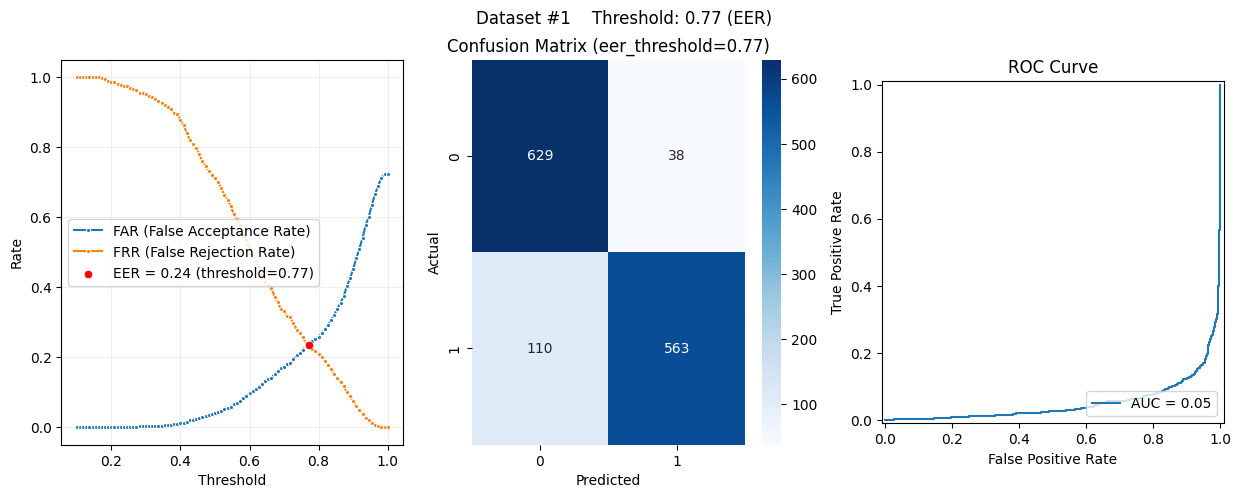

In [11]:
run_exp(df1, THRESHOLD_VALUES, dataset_name=f"Dataset #1")

Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.93      0.90       767
        True       0.91      0.86      0.88       673

    accuracy                           0.89      1440
   macro avg       0.90      0.89      0.89      1440
weighted avg       0.90      0.89      0.89      1440



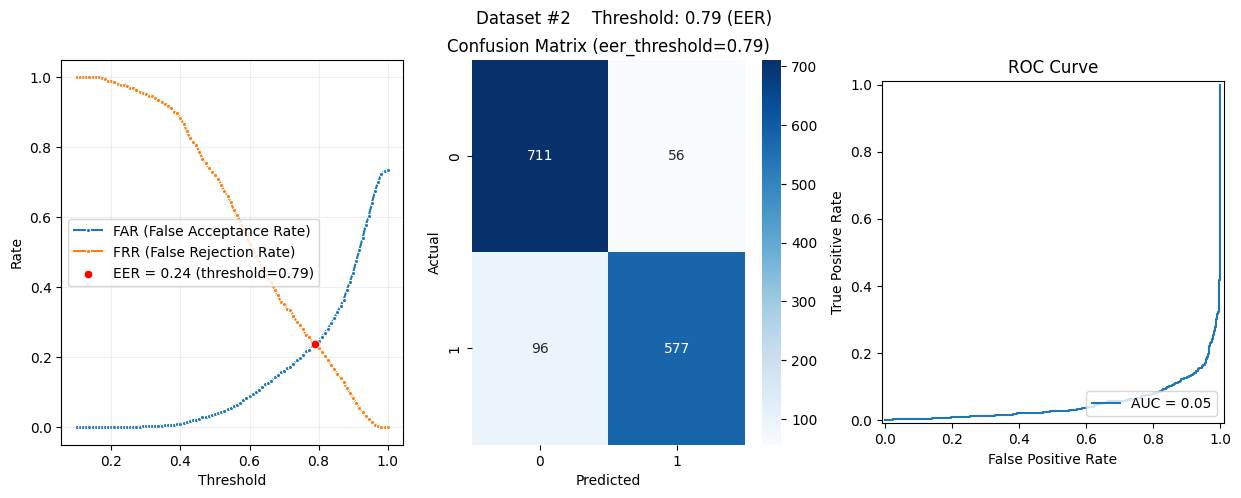

In [13]:
run_exp(df2, THRESHOLD_VALUES, dataset_name=f"Dataset #2")

Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



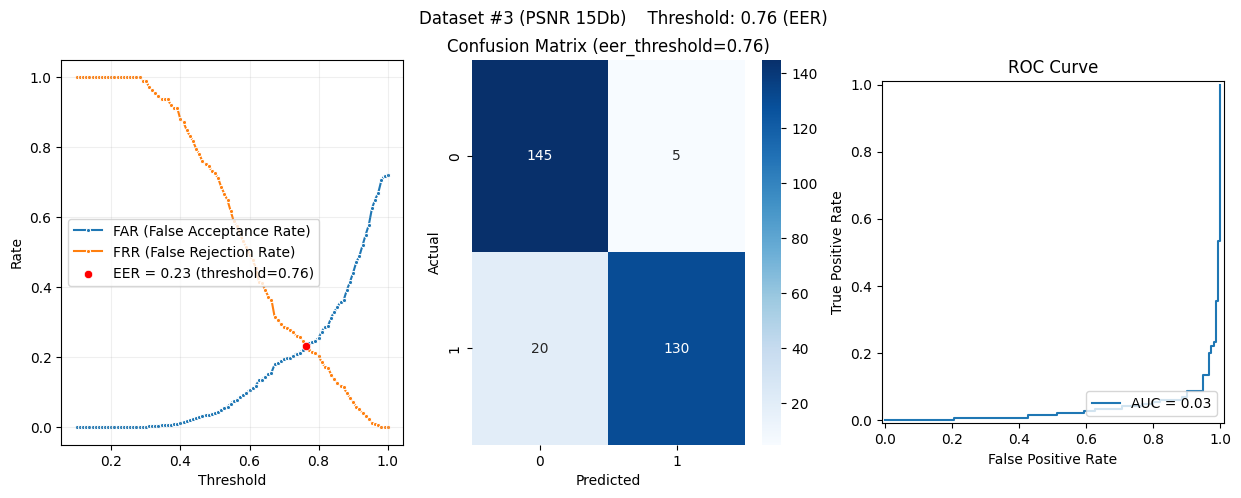

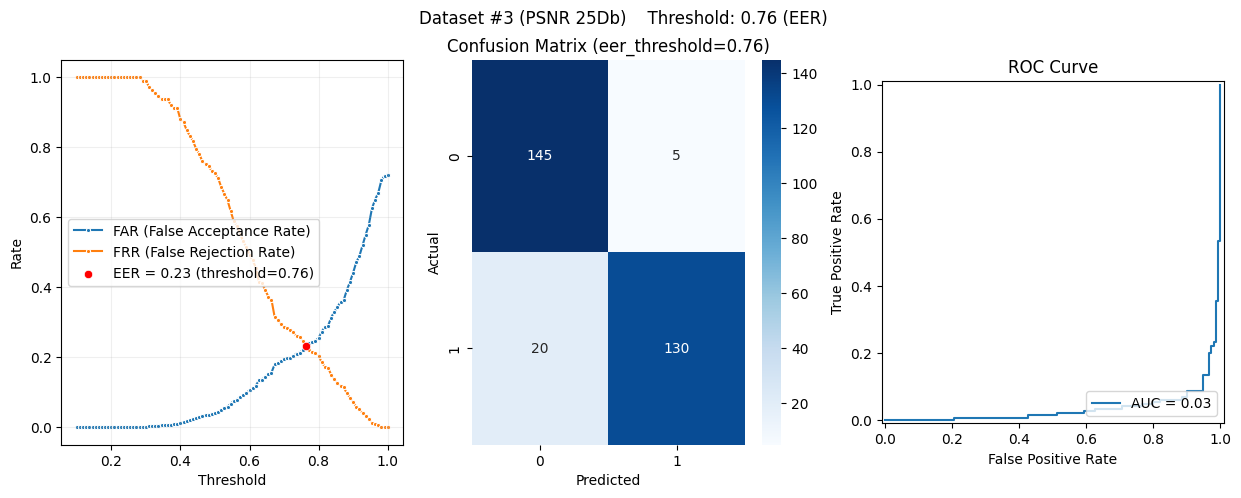

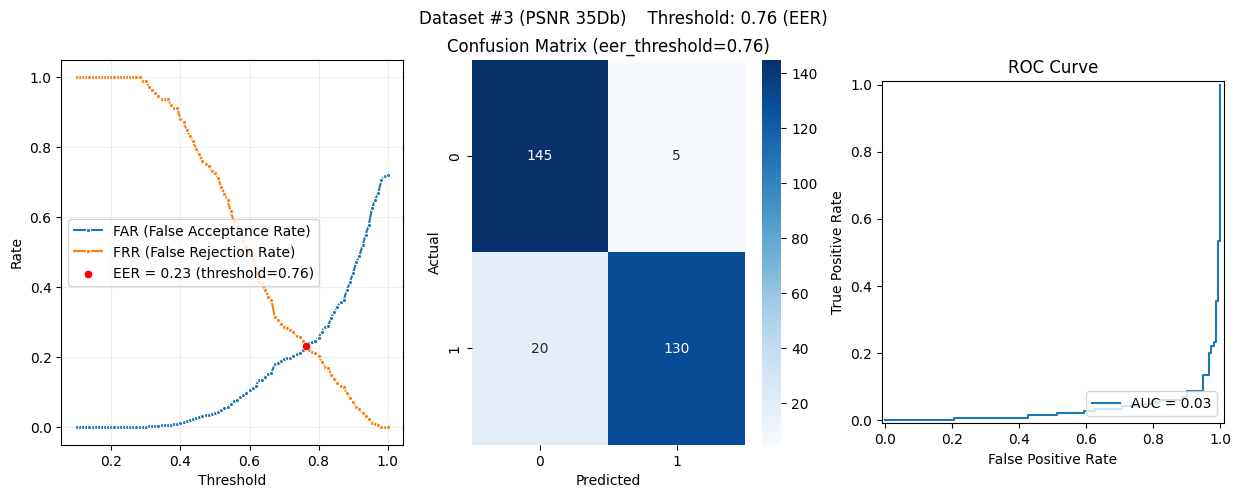

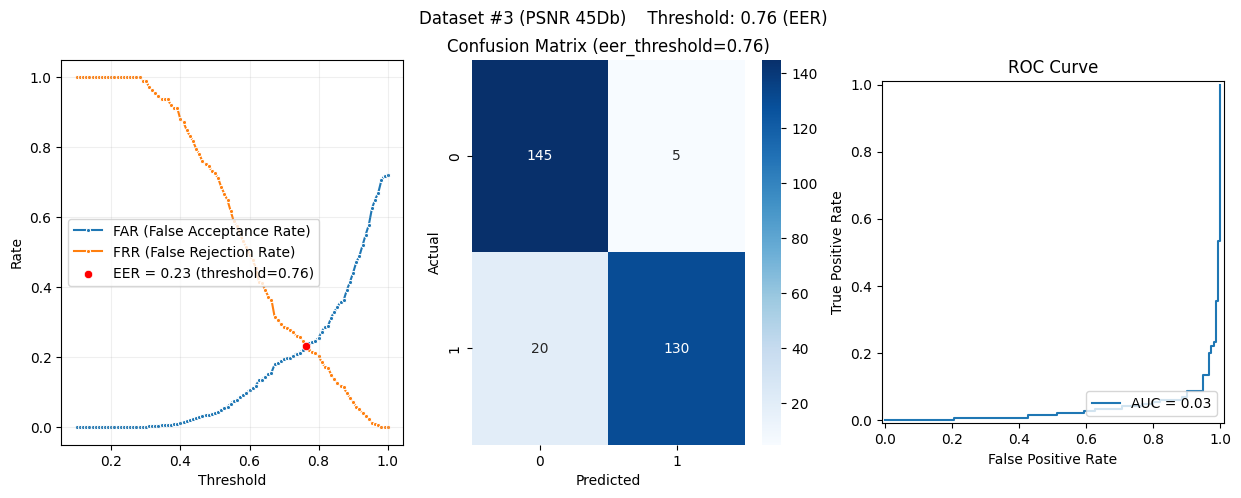

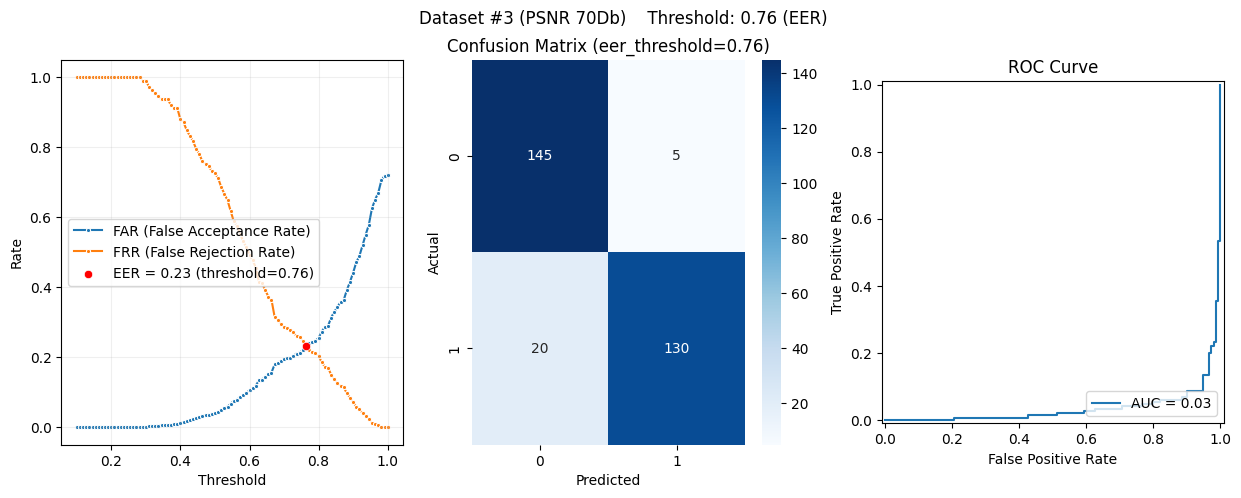

In [16]:
psnr_values = [15, 25, 35, 45, 70]
for psnr in psnr_values:
    df3_wth_fixed_paths = df3.copy()
    df3_wth_fixed_paths["image"] = df3_wth_fixed_paths["image"].apply(lambda x: f"df3_psnr{psnr}db/" + x)
    run_exp(df3_wth_fixed_paths, THRESHOLD_VALUES, dataset_name=f"Dataset #3 (PSNR {psnr}Db)")

Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Exp Thresholds:   0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       150
        True       0.96      0.87      0.91       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



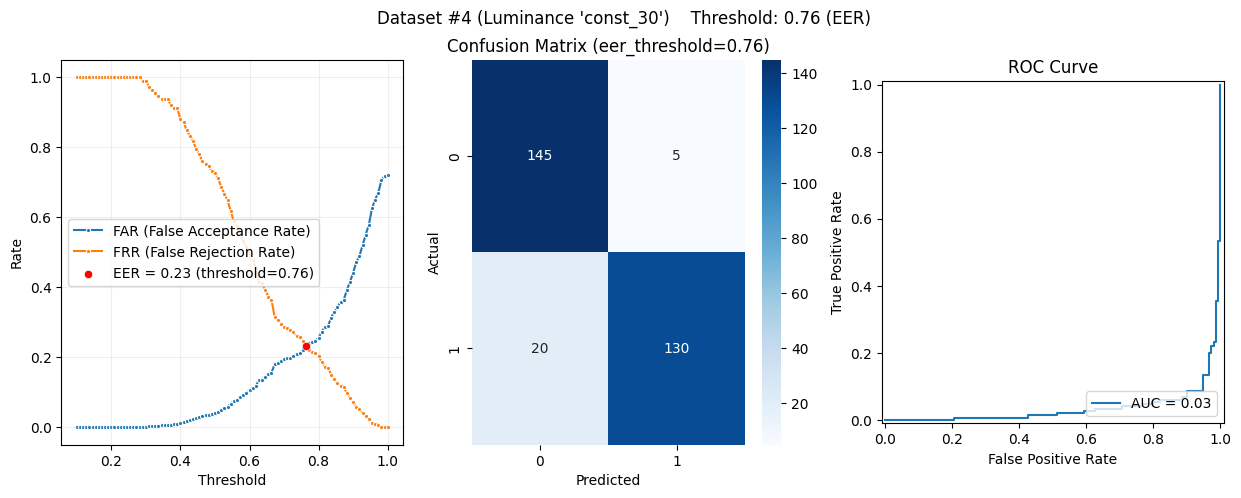

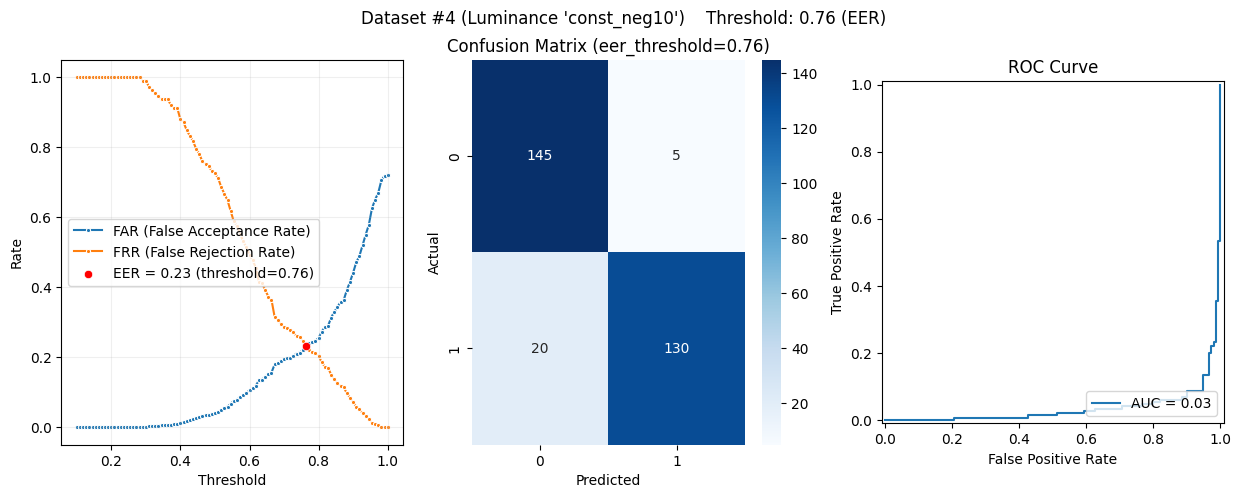

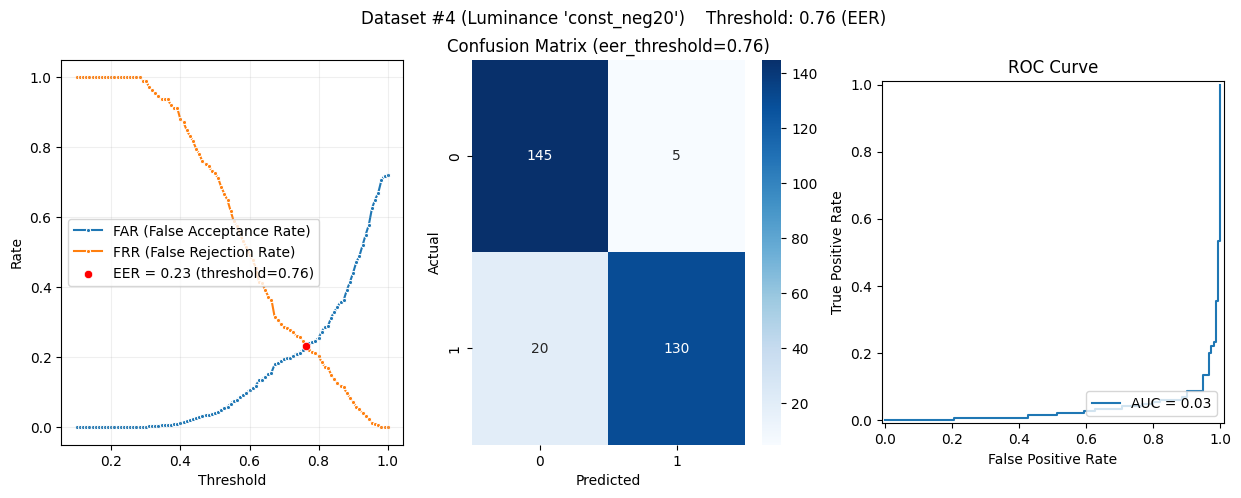

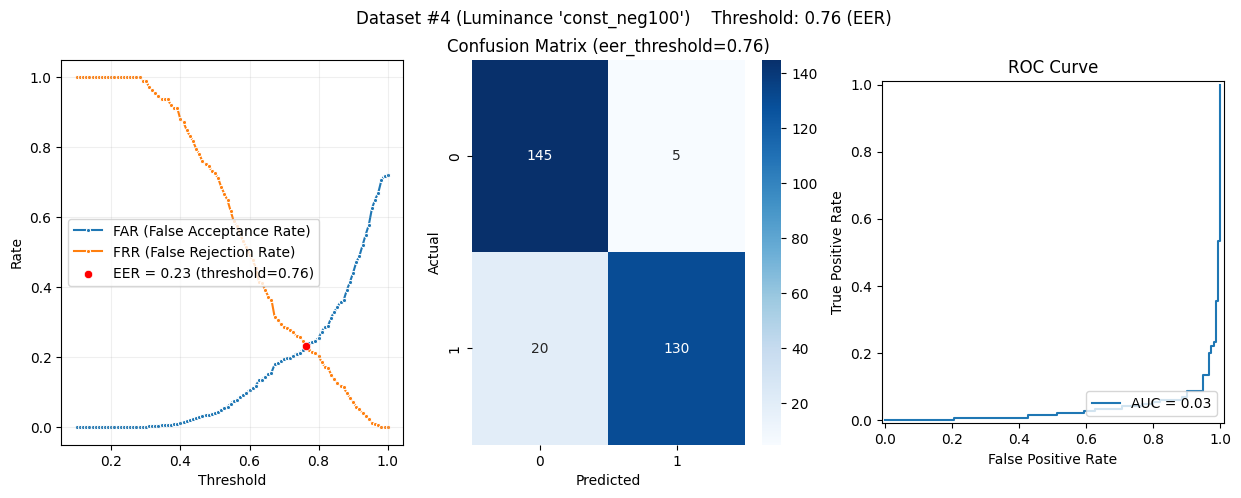

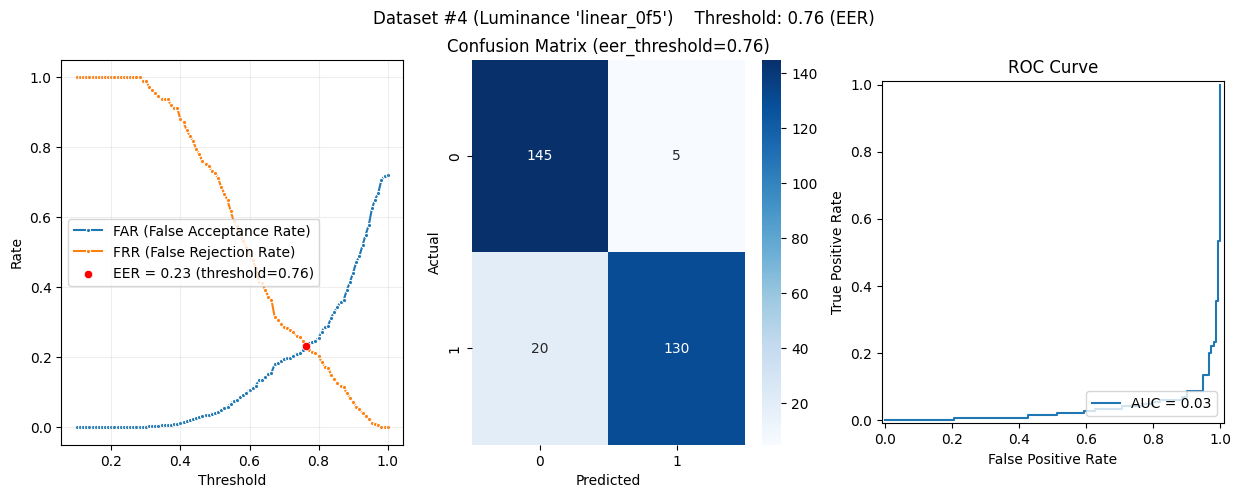

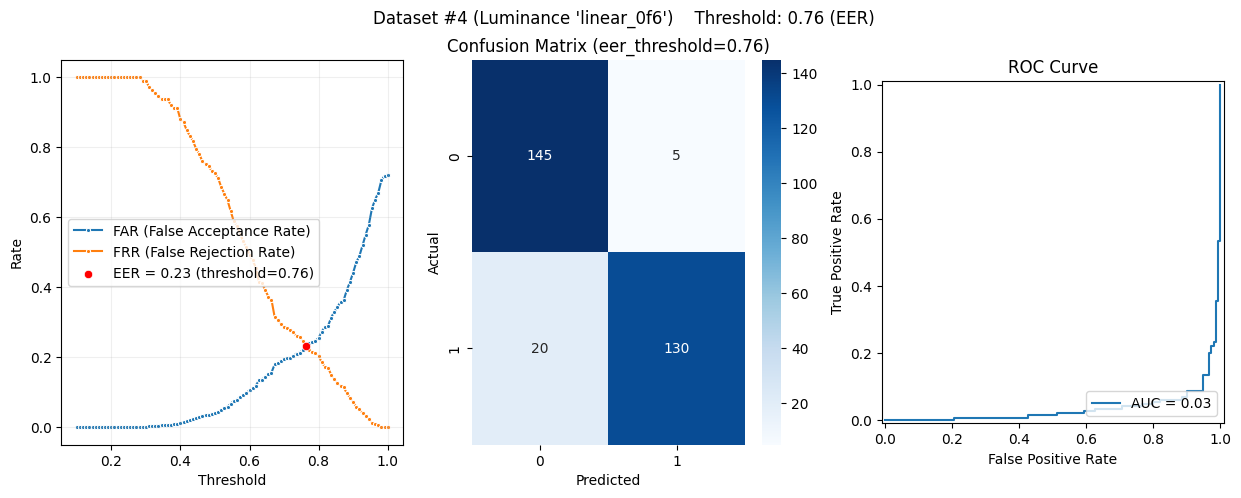

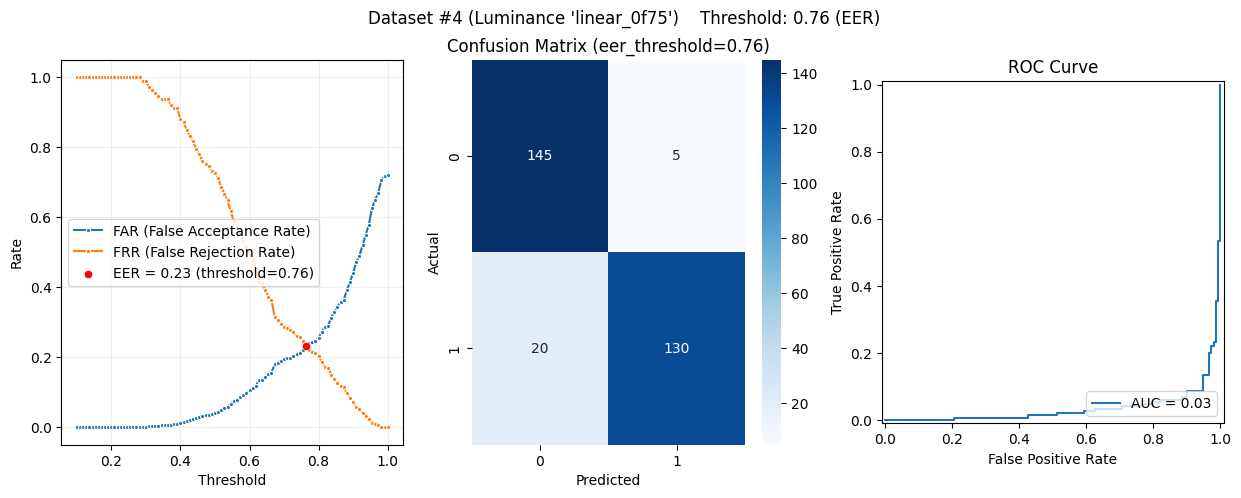

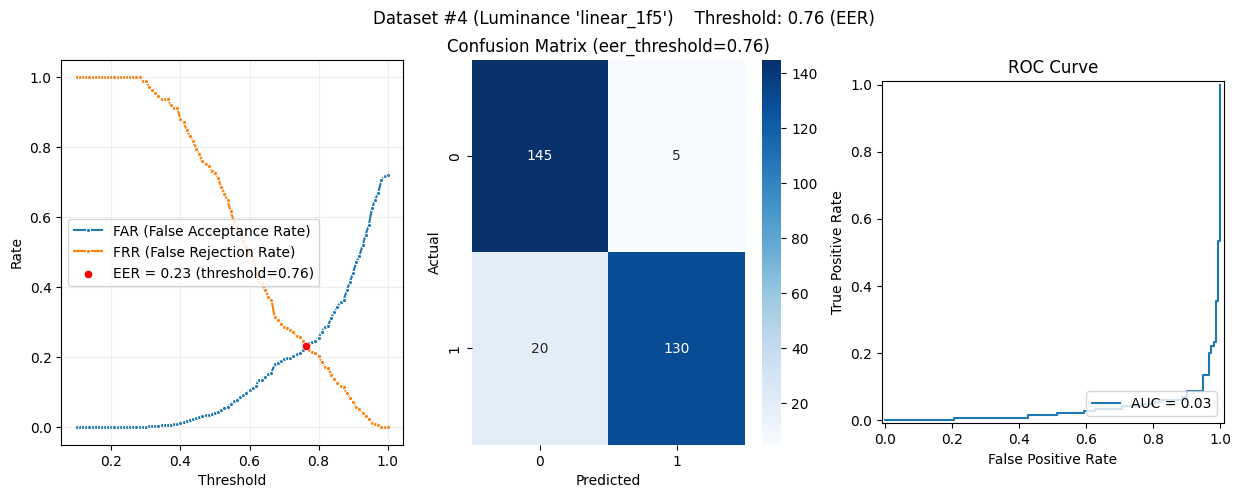

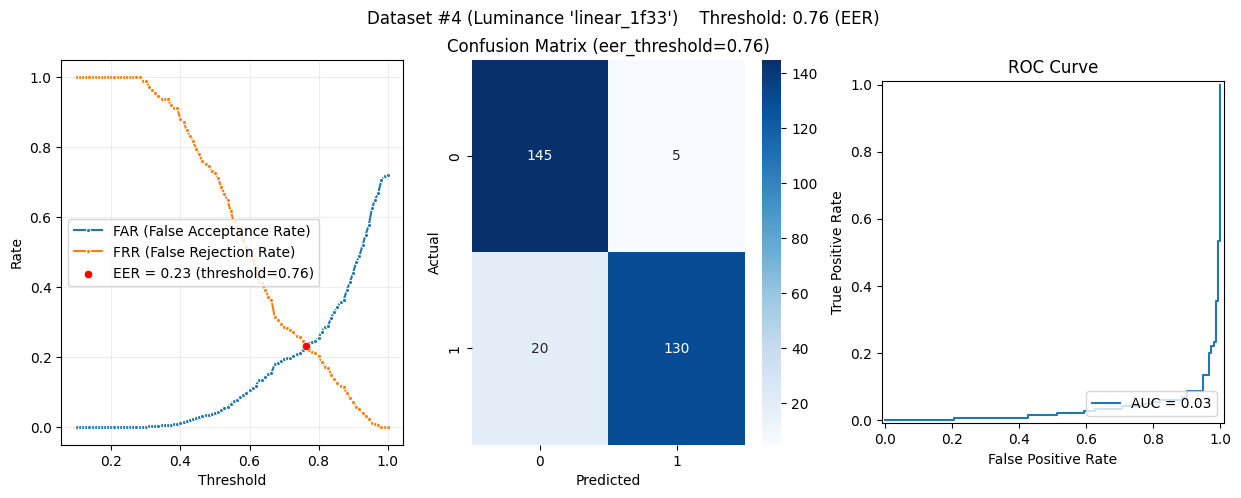

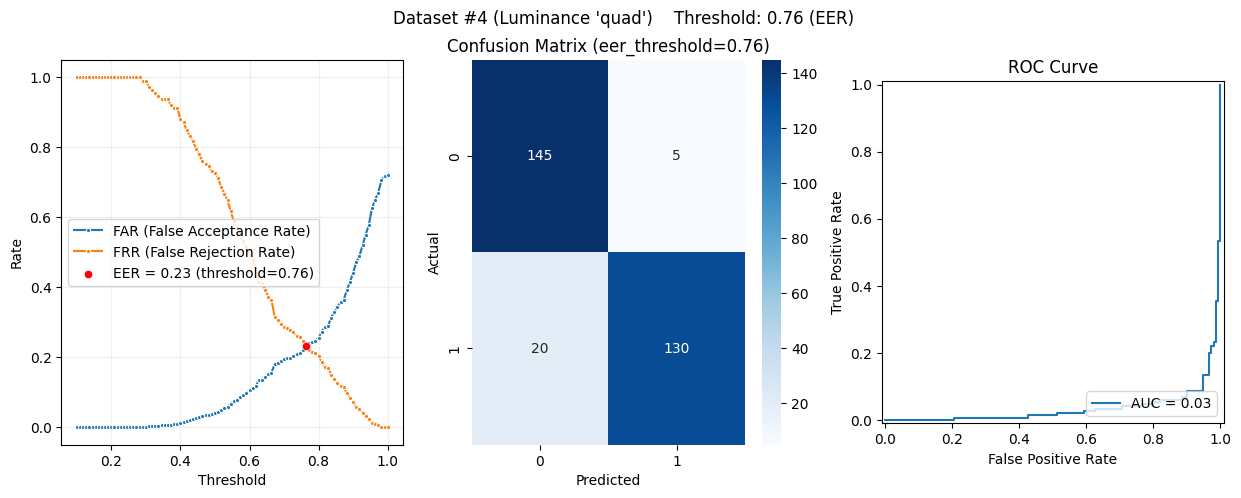

In [18]:
luminance_suffixes = [
    "const_30",
    "const_neg10",
    "const_neg20",
    "const_neg100",
    "linear_0f5",
    "linear_0f6",
    "linear_0f75",
    "linear_1f5",
    "linear_1f33",
    "quad"
]
for lum_suffix in luminance_suffixes:
    df4_wth_fixed_paths = df4.copy()
    df4_wth_fixed_paths["image"] = df4_wth_fixed_paths["image"].apply(lambda x: f"df4_luminance_{lum_suffix}/" + x)
    run_exp(df4_wth_fixed_paths, THRESHOLD_VALUES, dataset_name=f"Dataset #4 (Luminance '{lum_suffix}')")

In [12]:
from brisque import BRISQUE


brisque = BRISQUE(url=False)